In [1]:
last_data_date =  'Now'
duration_in_day = 1

In [2]:
from matplotlib import pyplot as plt

from lsst_efd_client import EfdClient,resample
import numpy as np
import pandas as pd
import datetime 
import asyncio


In [23]:
last_data_date="2025-10-25"

In [27]:
datetime.datetime.fromisoformat(last_data_date)

datetime.datetime(2025, 10, 25, 0, 0)

In [21]:
help(datetime)


Help on module datetime:

NAME
    datetime - Fast implementation of the datetime type.

MODULE REFERENCE
    https://docs.python.org/3.12/library/datetime.html

    The following documentation is automatically generated from the Python
    source files.  It may be incomplete, incorrect or include features that
    are considered implementation detail and may vary between Python
    implementations.  When in doubt, consult the module reference at the
    location listed above.

CLASSES
    builtins.object
        date
            datetime
        time
        timedelta
        tzinfo
            timezone

    class date(builtins.object)
     |  date(year, month, day) --> date object
     |
     |  Methods defined here:
     |
     |  __add__(self, value, /)
     |      Return self+value.
     |
     |  __eq__(self, value, /)
     |      Return self==value.
     |
     |  __format__(...)
     |      Formats self with strftime.
     |
     |  __ge__(self, value, /)
     |      Return sel

In [28]:
if last_data_date == 'Now':
    last_data_date_val = datetime.datetime.now(datetime.UTC)
else:
    last_data_date_val = datetime.datetime.fromisoformat(last_data_date)
first_data_date_val = last_data_date_val - datetime.timedelta(days=duration_in_day)
#
tstart=first_data_date_val.isoformat()
tend=last_data_date_val.isoformat()
# save plot on file
save_fig=False
# show plot on screen 
show_it = True
#
print( 'Looking for carousel controler error(s) \n between the ',tstart,' and the ',tend)
run_cur='%s_%s' % (first_data_date_val.isoformat(),last_data_date_val.isoformat())
# --- Automated configuration 
client = EfdClient('usdf_efd')
#
if save_fig  :
    output_data='/home/a/antilog/public_html/LsstCam/fes/'
    print('\n \nOutput will be saved in %s%s' % (output_data,run_cur))


Looking for carousel controler error(s) 
 between the  2025-09-25T00:00:00  and the  2025-10-25T00:00:00


In [4]:
#
def SaveFig(fig,File,run_cur='',raft_cur='',ccd_cur='',hdu=''):
    if len(hdu)==0 : 
        root_plt=os.path.join(output_data,run_cur,raft_cur,ccd_cur)
    else : 
        hdu_cur='%s' % (hdu)
        root_plt=os.path.join(output_data,run_cur,raft_cur,ccd_cur,hdu_cur)
    # 
    PlotFile=File.replace('.','_')
    PlotFile=PlotFile.replace(' ','_')
    os.makedirs(root_plt,exist_ok=True)
    plotfile=os.path.join(root_plt,PlotFile)
    print ('PlotFile=',plotfile)
    fig.savefig(plotfile,bbox_inches='tight')
    plt.close(fig) 
    return


In [16]:
#function to query the DB , and clean the variables never filled 
async def read_db(query,verbose=True,clean=True) :
    if verbose : 
        print("Running the query ")
        print(query)
    db_in =  await client.influx_client.query(query)
    for col in db_in.columns :
        len_col=len(db_in[db_in[col].notnull()])
        if clean :
            if len_col==0 : 
                db_in.drop(columns=[col],inplace=True)
                txt='dropped'
            else :
                txt='kept'
        else :
            txt='kept'  
        if verbose : print('%s (%s) = %d ' % (col,txt,len_col),end='\r' )
    if verbose : 
        print('Query completed                                                               \n')
    return db_in 

In [17]:
#query the data base to produce a panda object will all needed data 
#query = '''SELECT * FROM "lsst.MTCamera"."autogen"."lsst.MTCamera.fcs_canbus_controller" WHERE  time > '%s' AND time < '%s'  AND "Controller"='accelerobf' AND "Canbus"='canbus0' AND "Agent"='fcs' ''' % (tstart,tend)
#accelero =  await read_db(query)
#
query = '''SELECT * FROM "lsst.MTCamera"."autogen"."lsst.MTCamera.fcs_canbus_controller" WHERE  time > '%s' AND time < '%s'  AND "Controller"='carouselController' AND "Canbus"='canbus0' AND "Agent"='fcs' ''' % (tstart,tend)
car_controler =  await read_db(query)
#
#query = '''SELECT * FROM "lsst.MTCamera"."autogen"."lsst.MTCamera.fcs_canbus_plc" WHERE  time > '%s' AND time < '%s'  AND  "Canbus"='canbus0' AND "Agent"='fcs' ''' % (tstart,tend)
#plc =   await read_db(query)
#
#query = '''SELECT * FROM "lsst.MTCamera"."autogen"."lsst.MTCamera.fcs_carousel_clamp" WHERE  time > '%s' AND time < '%s'  AND  "Hardware"='carousel' AND "Agent"='fcs' ''' % (tstart,tend)
#clamp = await read_db(query)
#
query = '''SELECT * FROM "lsst.MTCamera"."autogen"."lsst.MTCamera.fcs_carousel" WHERE  time > '%s' AND time < '%s'  AND  "Hardware"='carousel' AND "Agent"='fcs' ''' % (tstart,tend)
carousel =  await read_db(query)
#
#query = '''SELECT * FROM "lsst.MTCamera"."autogen"."lsst.MTCamera.fcs_canbus_controller" WHERE  time > '%s' AND time < '%s' AND "Agent"='fcs' AND "Canbus"='canbus0' AND ("Controller"='clampXminusController' OR "Controller"='clampXplusController') AND "Hardware"='carousel' ''' % (tstart,tend)
#cl_car  = await read_db(query)
# 
#
#query = '''SELECT * FROM "lsst.MTCamera"."autogen"."lsst.MTCamera.fcs_carousel_brakes" WHERE  time > '%s' AND time < '%s'  AND  "Hardware"='carousel' AND "Agent"='fcs' ''' % (tstart,tend)
#brakes =  await read_db(query)

car=pd.merge_asof(car_controler,carousel,left_index=True, right_index=True, by=["Agent","Hardware"] ,suffixes=('_controler', ''), tolerance=pd.Timedelta("25ms"),direction='nearest' )
#car_plc=pd.merge_asof(car_cont,plc,left_index=True, right_index=True, by=["Agent","Hardware"] ,suffixes=('','_plc'), tolerance=pd.Timedelta("25ms"),direction='nearest' )
#car=pd.merge_asof(car_plc,brakes,left_index=True, right_index=True, by=["Agent","Hardware"] ,suffixes=('','_brakes'), tolerance=pd.Timedelta("25ms"),direction='nearest' )
#
#

Running the query 
SELECT * FROM "lsst.MTCamera"."autogen"."lsst.MTCamera.fcs_canbus_controller" WHERE  time > '2025-10-20T23:11:11.987529+00:00' AND time < '2025-11-19T23:11:11.987529+00:00'  AND "Controller"='carouselController' AND "Canbus"='canbus0' AND "Agent"='fcs' 
Query completed                                                               
Running the query 
SELECT * FROM "lsst.MTCamera"."autogen"."lsst.MTCamera.fcs_carousel" WHERE  time > '2025-10-20T23:11:11.987529+00:00' AND time < '2025-11-19T23:11:11.987529+00:00'  AND  "Hardware"='carousel' AND "Agent"='fcs' 
Query completed                                                               


In [7]:
# identify the rotation when we got a controler  error during the rotation 
state=car[car['state'].notnull()]['state'].to_numpy()
# get the time of each carousel controler "ON"
index_step_start=np.argwhere((state[0:-1]=='READY_TO_SWITCH_ON') & (state[1:] == 'OPERATION_ENABLE') )[:,0]
index_start=car[car['state'].notnull()].iloc[index_step_start].index
# get the time of each carousel Fault as controler in operation 
index_step_fault=np.argwhere((state[0:-1]=='OPERATION_ENABLE') & (state[1:] == 'FAULT') )[:,0]
index_fault=car[car['state'].notnull()].iloc[index_step_fault+1].index
# get when the controler went in fault and associate it to a start of controler 
index_step_fault_start=np.zeros((len(index_step_fault)),dtype=np.int_) 
for j  in range(len(index_step_fault)) :
    ifault=index_step_fault[j]
    last_start=-1
    for i in range(len(index_step_start)) :
        istart=index_step_start[i]
        if istart < ifault : 
            last_start=istart
        else :
            break
    if last_start > -1 : 
        index_step_fault_start[j]=last_start
#
index_fault_start=car[car['state'].notnull()].iloc[index_step_fault_start].index
#
index_30s=index_start+pd.Timedelta("30s")
#
index_fault_2_5s=index_fault_start+pd.Timedelta("2.5s")
index_m1s=index_start-pd.Timedelta("1s")
# duration prior  the failure 
durationPriorToFailure=(index_fault-index_fault_start).total_seconds()
# when does the Alert got triggered 
error=car[car['errorHistoryNB'].notnull()]['errorHistoryNB'].to_numpy()
index_step_error=np.argwhere((error[0:-1]==0) & (error[1:] > 0) )[:,0]
index_error=car[car['errorHistoryNB'].notnull()].iloc[index_step_error+1].index
# associate it to a fault 
index_step_error_start=np.zeros((len(index_step_fault)),dtype=np.int_) 
for j  in range(len(index_step_error_start)) :
    ifault=index_step_error[j]
    last_start=-1
    for i in range(len(index_step_start)) :
        istart=index_step_start[i]
        if istart < ifault : 
            last_start=ifault
        else :
            break
    if last_start > -1 : 
        index_step_error_start[j]=last_start
#
index_error_start=car[car['errorHistoryNB'].notnull()].iloc[index_step_error_start].index



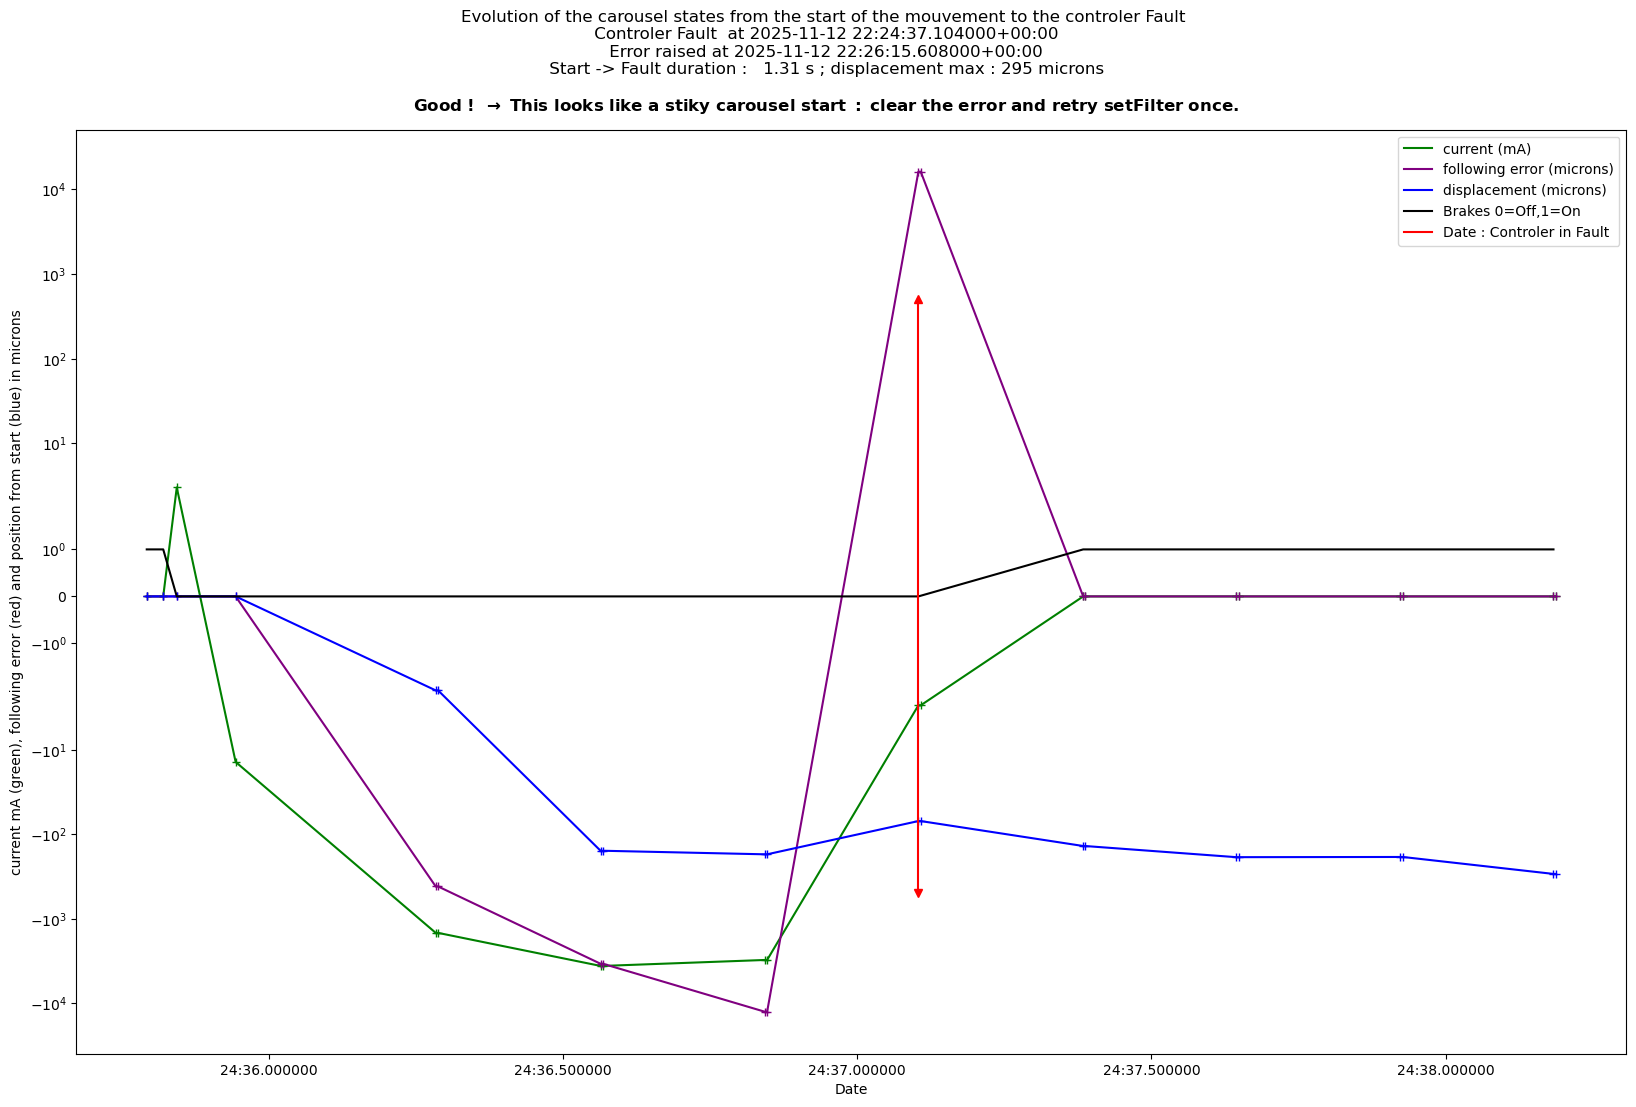

PlotFile= /home/a/antilog/public_html/LsstCam/fes/FES_ERROR/Carousel/StikyCarousel_2025-11-12-22:26:15


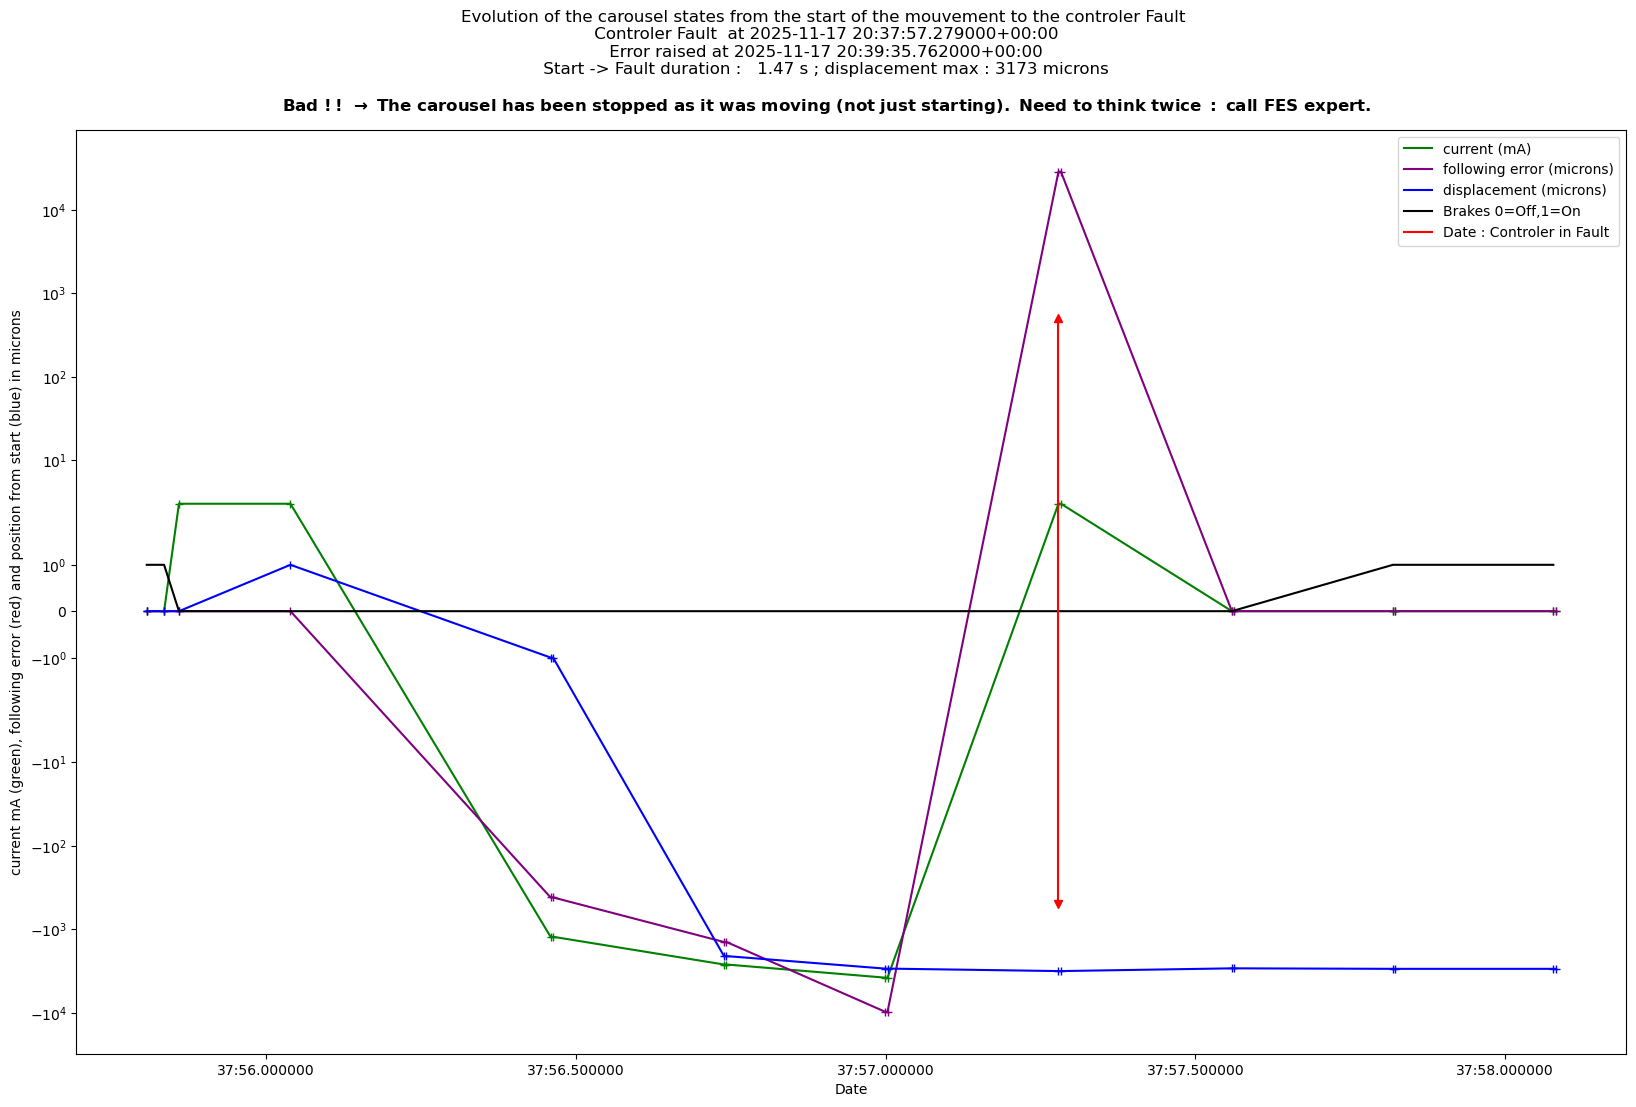

PlotFile= /home/a/antilog/public_html/LsstCam/fes/FES_ERROR/Carousel/StikyCarousel_2025-11-17-20:39:35


In [8]:
#plot from the start of the rotation to 2.5 s after the error the carousel rotation data
for i in range(len(index_fault_start)) : 
    fig=plt.figure(figsize=(20,12))
    displacement = max(abs(car[car['position'].notnull()]['position'].loc[index_fault_start[i]:index_fault_2_5s[i]]))
    xtratxt='Start -> Fault duration : %6.2f s ; displacement max : %d microns \n\n' %  (durationPriorToFailure[i],displacement)
    if (durationPriorToFailure[i]<3) and (displacement< 1000) :
        xtratxt+="$\\bf{Good\\ !\\ \\rightarrow \\ This \\ looks \\ like \\ a \\ stiky\\ carousel\\ start\\ :\\ clear\\ the\\ error\\ and\\ retry\\ setFilter\\ once. }$" 
    else :
        xtratxt+="$\\bf{Bad\\ !!\\ \\rightarrow \\ The\\ carousel\\ has\\ been\\ stopped\\ as\\ it\\ was\\ moving\\ (not\\ just\\ starting).\\ Need\\ to\\ think\\ twice\\ :\\ call\\ FES\\ expert.}$"  
    title='Evolution of the carousel states from the start of the mouvement to the controler Fault \n Controler Fault  at %s \n Error raised at %s \n %s' % (index_fault[i],index_error_start[i],xtratxt)
    fig.suptitle(title)
    plt.plot(car.loc[index_fault_start[i]:index_fault_2_5s[i]]['current'],color='g',label='current (mA)')
    plt.plot(car.loc[index_fault_start[i]:index_fault_2_5s[i]]['followingError'],color='purple',label='following error (microns)')
    plt.plot(car.loc[index_fault_start[i]:index_fault_2_5s[i]]['position'],color='b',label='displacement (microns)')
    plt.plot(car.loc[index_fault_start[i]:index_fault_2_5s[i]]['current'],'+',color='g')
    plt.plot(car.loc[index_fault_start[i]:index_fault_2_5s[i]]['followingError'],'+',color='purple')
    plt.plot(car.loc[index_fault_start[i]:index_fault_2_5s[i]]['position'],'+',color='b')
    plt.plot(car[car['brakeActivated'].notnull()].loc[index_fault_start[i]:index_fault_2_5s[i]]['brakeActivated'],color='black',label='Brakes 0=Off,1=On')
    plt.plot([index_fault[i],index_fault[i]],[-500,500],color='r',label='Date : Controler in Fault')
    plt.plot(index_fault[i],-500,'v',color='r')
    plt.plot(index_fault[i],500,'^',color='r')
    plt.yscale('symlog')
    plt.xlabel('Date')
    plt.ylabel('current mA (green), following error (red) and position from start (blue) in microns')
    plt.legend()
    plt.show()
    if save_fig :
        filename='StikyCarousel_%s' %(index_error_start[i].strftime('%Y-%m-%d-%X')) 
        SaveFig(fig,File=filename,run_cur='FES_ERROR',raft_cur='Carousel')